In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, GlobalAvgPool2D, Add, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score

from tensorflow.keras import Sequential, layers, losses
import cv2 as cv
import matplotlib.image

In [2]:
class_list = os.listdir('../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/')
class_directory = {"Ak": 0, "Ala_Idris": 1, "Buzgulu": 2, "Dimnit": 3, "Nazli": 4}

train_data = []

train_labels = []

for class_folder in class_list:
    if class_folder[0] != 'G':
        file_names = os.listdir(os.path.join("../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/", class_folder))
        for file_name in file_names:
            image = matplotlib.image.imread(os.path.join("../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/", class_folder, file_name))
            try:
                resized = cv.resize(image, (320,320), interpolation=cv.INTER_AREA)
                train_data.append(resized)
                train_labels.append(class_directory[class_folder])

            except:
                break
train_data = np.array(train_data)
train_labels = np.array(train_labels)

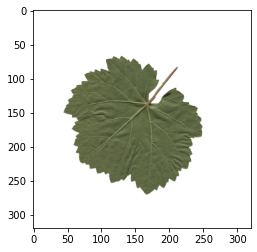

In [3]:
plt.imshow(train_data[0])

In [4]:
train_labels = train_labels.reshape((-1, 1))
train_data.shape, train_labels.shape

((500, 320, 320, 4), (500, 1))

In [5]:
from sklearn.utils import shuffle
train_data, train_labels = shuffle(train_data, train_labels)

In [6]:
train_data[0].shape

(320, 320, 4)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, shuffle=True, random_state=101)

## Autoencoder MODEL for Denoising the images

In [8]:
input = layers.Input(shape=(320, 320, 4))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)


x = layers.Flatten()(x)
latent_space = layers.Dense(1024)(x)
x = layers.Dense(20*20*16)(latent_space)
x = layers.Reshape(target_shape=(20,20,16))(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(4, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
encoded = Model(input, latent_space)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

2022-08-04 19:32:19.721963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 19:32:19.831713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 19:32:19.832542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 4)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 320, 320, 64)      2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 160, 160, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0     

2022-08-04 19:32:19.834543: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 19:32:19.834869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 19:32:19.835614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 19:32:19.836266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
autoencoder.fit(
    x=X_train,
    y=X_train,
#     train_generator_resnet50,
    epochs=40,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
#     validation_data = val_generator_resnet50
)

2022-08-04 19:32:23.538745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-08-04 19:32:25.180684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


13/13 [==============================] - 13s 390ms/step - loss: 0.6644 - val_loss: 0.4534
Epoch 2/40
13/13 [==============================] - 4s 284ms/step - loss: 0.3759 - val_loss: 0.3457
Epoch 3/40
13/13 [==============================] - 3s 271ms/step - loss: 0.3351 - val_loss: 0.3180
Epoch 4/40
13/13 [==============================] - 3s 266ms/step - loss: 0.3116 - val_loss: 0.3045
Epoch 5/40
13/13 [==============================] - 3s 259ms/step - loss: 0.3020 - val_loss: 0.3004
Epoch 6/40
13/13 [==============================] - 3s 262ms/step - loss: 0.2966 - val_loss: 0.2948
Epoch 7/40
13/13 [==============================] - 3s 260ms/step - loss: 0.2915 - val_loss: 0.2898
Epoch 8/40
13/13 [==============================] - 3s 262ms/step - loss: 0.2859 - val_loss: 0.2841
Epoch 9/40
13/13 [==============================] - 3s 267ms/step - loss: 0.2782 - val_loss: 0.2749
Epoch 10/40
13/13 [==============================] - 3s 259ms/step - loss: 0.2682 - val_loss: 0.2662
Epoch 11/

In [10]:
encoded_train = encoded.predict(X_train)
encoded_test = encoded.predict(X_test)

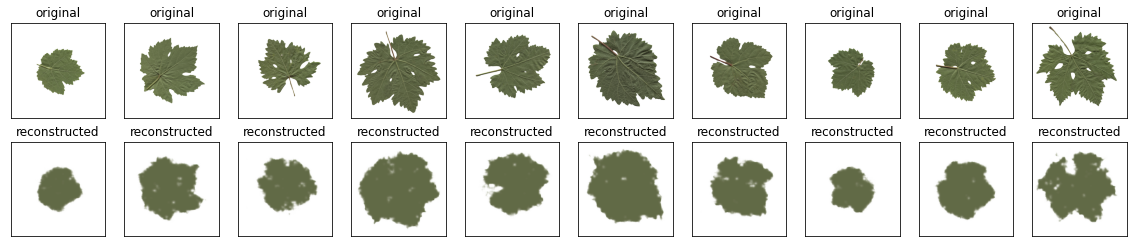

In [11]:

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(autoencoder.predict(X_test)[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## MLP

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier

In [13]:
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=32, verbose=False, early_stopping=True)

In [14]:
test = []
for a in y_train:
    test.append(a[0])
test = np.array(test)

test.shape

(400,)

In [15]:
clf.fit(encoded_train, test)

MLPClassifier(batch_size=32, early_stopping=True, hidden_layer_sizes=(1024,))

In [16]:
y_pred = clf.predict(encoded_test)

In [17]:
tt = []
for a in y_test:
    tt.append(a[0])
tt = np.array(tt)
tt.shape

(100,)

In [18]:
print(classification_report(tt,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.38      0.38        21
           1       0.38      0.46      0.42        24
           2       0.47      0.39      0.43        23
           3       0.11      0.07      0.09        14
           4       0.41      0.50      0.45        18

    accuracy                           0.38       100
   macro avg       0.35      0.36      0.35       100
weighted avg       0.37      0.38      0.37       100



In [19]:
main_path = '../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/'
path_Ak = main_path + 'Ak'
path_Ala_Idris = main_path + 'Ala_Idris'
path_Buzgulu = main_path + 'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'

df = pd.DataFrame()


df['images'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)



classes = []
paths = []
for image in df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

df['classes'] = classes
df['path'] = paths

In [20]:
df.head()

,images,classes,path
0,Ak (97).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
1,Ak (75).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
2,Ak (16).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
3,Ak (61).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
4,Ak (95).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) 

## ResNet MODEL

In [22]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
    ) 
train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_val,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
resnet50_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    ) 
test_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_test,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [23]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50(input_shape=(227, 227,3), include_top=False, weights='imagenet')

    resnet_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = resnet_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    resnet = tf.keras.Model(inputs, output)
#     resnet.summary()
    resnet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return resnet

In [24]:

resnet = create_model()
save_best = tf.keras.callbacks.ModelCheckpoint("best_resnet_model.h5", save_best_only=True)
history_resnet50 = resnet.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=45,
      batch_size=32,
      verbose=2, callbacks=[save_best])   

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/45
10/10 - 12s - loss: 2.0230 - accuracy: 0.2812 - val_loss: 1.5376 - val_accuracy: 0.2750


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/45
10/10 - 8s - loss: 1.5233 - accuracy: 0.3313 - val_loss: 1.3873 - val_accuracy: 0.4750
Epoch 3/45
10/10 - 9s - loss: 1.2920 - accuracy: 0.4875 - val_loss: 1.3024 - val_accuracy: 0.4875
Epoch 4/45
10/10 - 8s - loss: 1.2116 - accuracy: 0.5031 - val_loss: 1.1715 - val_accuracy: 0.5625
Epoch 5/45
10/10 - 7s - loss: 1.1055 - accuracy: 0.5781 - val_loss: 1.0646 - val_accuracy: 0.6250
Epoch 6/45
10/10 - 7s - loss: 0.9162 - accuracy: 0.6562 - val_loss: 1.1157 - val_accuracy: 0.5625
Epoch 7/45
10/10 - 8s - loss: 0.8834 - accuracy: 0.6687 - val_loss: 0.8640 - val_accuracy: 0.7000
Epoch 8/45
10/10 - 7s - loss: 0.7993 - accuracy: 0.7000 - val_loss: 0.7887 - val_accuracy: 0.7625
Epoch 9/45
10/10 - 7s - loss: 0.7610 - accuracy: 0.7125 - val_loss: 0.7781 - val_accuracy: 0.7750
Epoch 10/45
10/10 - 7s - loss: 0.6958 - accuracy: 0.7250 - val_loss: 0.6689 - val_accuracy: 0.7125
Epoch 11/45
10/10 - 8s - loss: 0.6576 - accuracy: 0.7563 - val_loss: 0.7477 - val_accuracy: 0.6500
Epoch 12/45
10/10 

In [25]:
resnet.evaluate(test_generator_resnet50)

4/4 [==============================] - 1s 187ms/step - loss: 0.6065 - accuracy: 0.8000


[0.6065110564231873, 0.800000011920929]

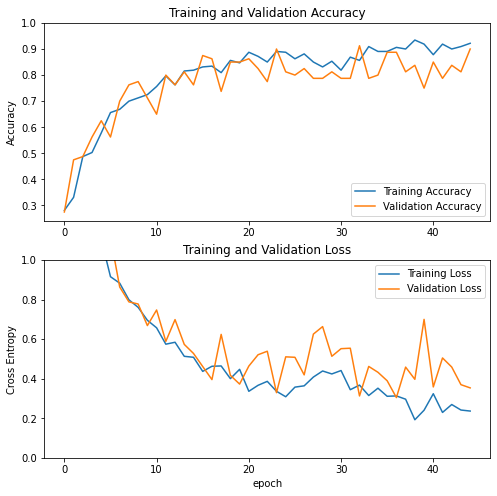

In [26]:
acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']

loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning

<AxesSubplot:>

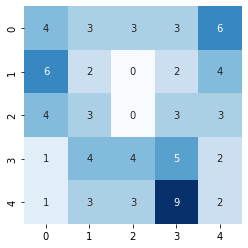

In [31]:
Y_pred = resnet.predict(val_generator_resnet50)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator_resnet50.classes, y_pred)
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

### Use different Seeds for Training

In [32]:
import random
seed = random.randint(0,100)
mean_accuracy = 0
for i in range(10):
    
    X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed) 
    
    resnet50_datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.10,
            brightness_range=[0.6,1.4],
            channel_shift_range=0.7,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=preprocess_input
    ) 
    train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
            X_train,  
            x_col='path',
            y_col='classes',
            target_size=(227, 227),  
            batch_size=32,
            class_mode="categorical",
            shuffle=True,
    )
    val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
            X_val,  
            x_col='path',
            y_col='classes',
            target_size=(227, 227),  
            batch_size=32,
            class_mode="categorical",
            shuffle=True,
    )
    resnet50_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
        ) 
    test_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
            X_test,  
            x_col='path',
            y_col='classes',
            target_size=(227, 227),  
            batch_size=32,
            class_mode="categorical",
            shuffle=True,
    )
    
    
    resnet_model = tf.keras.applications.ResNet50(input_shape=(227, 227,3), include_top=False, weights='imagenet')

    resnet_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = resnet_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    resnet = tf.keras.Model(inputs, output)

    resnet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    history_resnet = resnet.fit(train_generator_resnet50,  
                                  epochs=30)
    
    val_res = resnet.evaluate(val_generator_resnet50)
    test_res = resnet.evaluate(test_generator_resnet50)
    print("Validation Result: ", val_res)
    print("Test Result: ", test_res)
    mean_accuracy += test_res[1]
print("mean accuracy with 10 random seeds: ", mean_accuracy)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
10/10 [==============================] - 9s 624ms/step - loss: 2.0446 - accuracy: 0.2375
Epoch 2/30
10/10 [==============================] - 6s 591ms/step - loss: 1.5426 - accuracy: 0.3438
Epoch 3/30
10/10 [==============================] - 6s 562ms/step - loss: 1.4078 - accuracy: 0.4187
Epoch 4/30
10/10 [==============================] - 6s 593ms/step - loss: 1.2799 - accuracy: 0.4688
Epoch 5/30
10/10 [==============================] - 6s 568ms/step - loss: 1.0844 - accuracy: 0.5500
Epoch 6/30
10/10 [==============================] - 6s 600ms/step - loss: 0.9862 - accuracy: 0.6062
Epoch 7/30
10/10 [==============================] - 7s 660ms/step - loss: 0.9834 - accuracy: 0.6156
Epoch 8/30
10/10 [==============================] - 6s 567ms/step - loss: 0.9364 - accuracy: 0.6094
Epoch 9/30
10/10 [===

In [33]:
print("Final Mean Accuracy: ", mean_accuracy/10.)

Final Mean Accuracy:  0.7720000088214874


## Cross Validation 

In [34]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import KFold, StratifiedKFold
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 
resnet50_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)


Y = y_train

for train_index, val_index in kf.split(np.zeros(400),Y):

    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]

    
    training_set = resnet50_datagen.flow_from_dataframe(dataframe = training_data, 
                                                      x_col="path", 
                                                      y_col="classes",
                                                      class_mode="categorical",
                                                      target_size=(227, 227), 
                                                      batch_size=32)

    validation_set = resnet50_datagen.flow_from_dataframe(dataframe = validation_data, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    test_set = resnet50_datagen.flow_from_dataframe(dataframe = X_test, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    
    resnet_model = tf.keras.applications.ResNet50(input_shape=(227, 227,3), include_top=False, weights='imagenet')

    resnet_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = resnet_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    resnet = tf.keras.Model(inputs, output)

    resnet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    history_resnet = resnet.fit(training_set,  
                                  epochs=30)



    val_res = resnet.evaluate(validation_set)
    test_res = resnet.evaluate(test_set)
    print("Validation Result: ", val_res)
    print("Test Result: ", test_res)


Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
12/12 [==============================] - 10s 556ms/step - loss: 2.0013 - accuracy: 0.2472
Epoch 2/30
12/12 [==============================] - 7s 549ms/step - loss: 1.6513 - accuracy: 0.2611
Epoch 3/30
12/12 [==============================] - 7s 575ms/step - loss: 1.4159 - accuracy: 0.3750
Epoch 4/30
12/12 [==============================] - 7s 568ms/step - loss: 1.2450 - accuracy: 0.4639
Epoch 5/30
12/12 [==============================] - 6s 529ms/step - loss: 1.1644 - accuracy: 0.5361
Epoch 6/30
12/12 [==============================] - 7s 525ms/step - loss: 0.9243 - accuracy: 0.6778
Epoch 7/30
12/12 [==============================] - 7s 555ms/step - loss: 0.9102 - accuracy: 0.6556
Epoch 8/30
12/12 [==============================] - 7s 574ms/step - loss: 0.8027 - accuracy: 0.6972
Epoch 9/30
12/12 [==

## VGG MODEL

In [35]:
from keras.applications.vgg19 import preprocess_input

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) 

In [37]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_train,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_val,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
test_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_test,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [38]:
vgg19_model = tf.keras.applications.VGG19(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

vgg19_model.trainable = False

inputs = Input((227, 227,3))

base_model_output = vgg19_model(inputs)

x = GlobalAvgPool2D()(base_model_output)

x = Dense(units= 512, activation='relu')(x)
x = Dense(units= 256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(units= 5, activation='softmax')(x)


vgg19 = tf.keras.Model(inputs, output)
vgg19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 227, 227, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_21  (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
___________________________________________________________

In [39]:
vgg19.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [40]:
save_best = tf.keras.callbacks.ModelCheckpoint("best_vgg_model.h5", save_best_only=True)
history_vgg = vgg19.fit(
      train_generator_vgg,
      validation_data=val_generator_vgg,
      epochs=45,
      verbose=2, callbacks=[save_best])

Epoch 1/45
10/10 - 13s - loss: 2.7323 - accuracy: 0.2562 - val_loss: 1.6874 - val_accuracy: 0.2500
Epoch 2/45
10/10 - 8s - loss: 1.4698 - accuracy: 0.4219 - val_loss: 1.1874 - val_accuracy: 0.4625
Epoch 3/45
10/10 - 7s - loss: 1.0610 - accuracy: 0.5688 - val_loss: 1.1198 - val_accuracy: 0.5875
Epoch 4/45
10/10 - 8s - loss: 0.9809 - accuracy: 0.6250 - val_loss: 0.9146 - val_accuracy: 0.6500
Epoch 5/45
10/10 - 8s - loss: 0.8734 - accuracy: 0.6656 - val_loss: 0.8058 - val_accuracy: 0.7000
Epoch 6/45
10/10 - 8s - loss: 0.8140 - accuracy: 0.6875 - val_loss: 0.7895 - val_accuracy: 0.6875
Epoch 7/45
10/10 - 7s - loss: 0.7444 - accuracy: 0.7094 - val_loss: 0.7584 - val_accuracy: 0.7500
Epoch 8/45
10/10 - 8s - loss: 0.6337 - accuracy: 0.7594 - val_loss: 0.6758 - val_accuracy: 0.7875
Epoch 9/45
10/10 - 8s - loss: 0.6556 - accuracy: 0.7625 - val_loss: 0.8737 - val_accuracy: 0.6875
Epoch 10/45
10/10 - 7s - loss: 0.6125 - accuracy: 0.7906 - val_loss: 0.6391 - val_accuracy: 0.7875
Epoch 11/45
10/10 

In [41]:
vgg19.evaluate(test_generator_vgg)

4/4 [==============================] - 3s 713ms/step - loss: 0.7658 - accuracy: 0.7600


[0.7657650113105774, 0.7599999904632568]

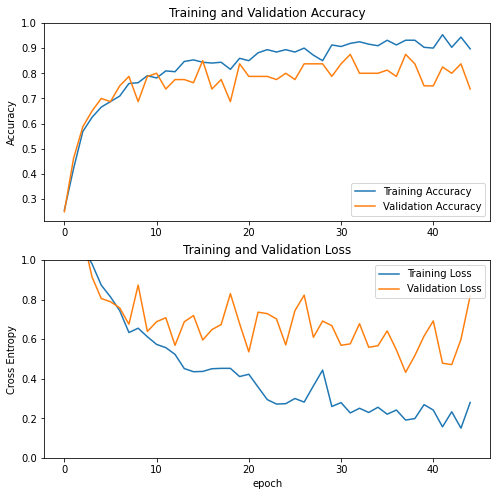

In [42]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<AxesSubplot:>

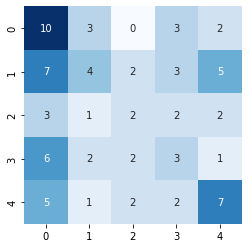

In [43]:
Y_pred = vgg19.predict(val_generator_vgg)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator_vgg.classes, y_pred)
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

## Cross Validation

In [44]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.model_selection import KFold, StratifiedKFold
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 
resnet50_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)


Y = y_train

for train_index, val_index in kf.split(np.zeros(400),Y):

    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]

    
    training_set = resnet50_datagen.flow_from_dataframe(dataframe = training_data, 
                                                      x_col="path", 
                                                      y_col="classes",
                                                      class_mode="categorical",
                                                      target_size=(227, 227), 
                                                      batch_size=32)

    validation_set = resnet50_datagen.flow_from_dataframe(dataframe = validation_data, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    test_set = resnet50_datagen.flow_from_dataframe(dataframe = X_test, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    
    vgg19_model = tf.keras.applications.VGG19(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

    vgg19_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = vgg19_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    vgg19 = tf.keras.Model(inputs, output)
    
    vgg19.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    history_vgg = vgg19.fit(training_set,  
                                  epochs=30)



    val_res = vgg19.evaluate(validation_set)
    test_res = vgg19.evaluate(test_set)
    print("Validation Result: ", val_res)
    print("Test Result: ", test_res)

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
12/12 [==============================] - 7s 568ms/step - loss: 2.3179 - accuracy: 0.2694
Epoch 2/30
12/12 [==============================] - 7s 551ms/step - loss: 1.3088 - accuracy: 0.4806
Epoch 3/30
12/12 [==============================] - 7s 551ms/step - loss: 1.0352 - accuracy: 0.5944
Epoch 4/30
12/12 [==============================] - 7s 575ms/step - loss: 0.9423 - accuracy: 0.6389
Epoch 5/30
12/12 [==============================] - 7s 579ms/step - loss: 0.8191 - accuracy: 0.7000
Epoch 6/30
12/12 [==============================] - 7s 554ms/step - loss: 0.8145 - accuracy: 0.7167
Epoch 7/30
12/12 [==============================] - 6s 524ms/step - loss: 0.7461 - accuracy: 0.7278
Epoch 8/30
12/12 [==============================] - 7s 555ms/step - loss: 0.6481 - accuracy: 0.7444
Epoch 9/30
12/12 [===

## MobileNet

In [45]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [46]:
mobilenet_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_mobilenet = mobilenet_datagen.flow_from_dataframe(
        X_train,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_mobilenet = mobilenet_datagen.flow_from_dataframe(
        X_val,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.


In [47]:
mobilnet_model = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

mobilnet_model.trainable = False

inputs = Input((227, 227,3))

base_model_output = mobilnet_model(inputs)

x = GlobalAvgPool2D()(base_model_output)

x = Dense(units= 512, activation='relu')(x)
x = Dense(units= 256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(units= 5, activation='softmax')(x)


mobilenet = tf.keras.Model(inputs, output)
mobilenet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 227, 227, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_32  (None, 1280)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_99 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_____________________________________________________________

In [48]:
mobilenet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [49]:
save_best = tf.keras.callbacks.ModelCheckpoint("best_mobilenet_model.h5", save_best_only=True)
history_mobilenet = mobilenet.fit(
      train_generator_mobilenet,
      validation_data=val_generator_mobilenet,
      epochs=50,
      callbacks=[save_best])

Epoch 1/50
13/13 [==============================] - 12s 780ms/step - loss: 1.6981 - accuracy: 0.3300 - val_loss: 1.0514 - val_accuracy: 0.6750


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
13/13 [==============================] - 9s 717ms/step - loss: 1.0783 - accuracy: 0.5575 - val_loss: 0.7980 - val_accuracy: 0.7250
Epoch 3/50
13/13 [==============================] - 9s 664ms/step - loss: 0.8909 - accuracy: 0.6525 - val_loss: 0.6924 - val_accuracy: 0.7750
Epoch 4/50
13/13 [==============================] - 8s 629ms/step - loss: 0.7523 - accuracy: 0.7200 - val_loss: 0.6886 - val_accuracy: 0.7375
Epoch 5/50
13/13 [==============================] - 9s 708ms/step - loss: 0.6647 - accuracy: 0.7550 - val_loss: 0.5294 - val_accuracy: 0.7750
Epoch 6/50
13/13 [==============================] - 8s 629ms/step - loss: 0.6553 - accuracy: 0.7500 - val_loss: 0.6524 - val_accuracy: 0.7500
Epoch 7/50
13/13 [==============================] - 9s 685ms/step - loss: 0.6195 - accuracy: 0.7850 - val_loss: 0.5624 - val_accuracy: 0.8000
Epoch 8/50
13/13 [==============================] - 8s 650ms/step - loss: 0.6657 - accuracy: 0.7400 - val_loss: 0.4824 - val_accuracy: 0.8500
Epoch 

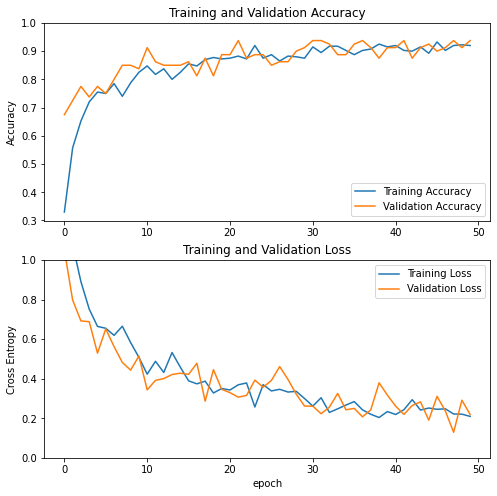

In [50]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']

loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<AxesSubplot:>

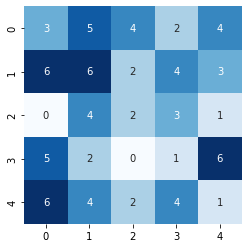

In [51]:
Y_pred = mobilenet.predict(val_generator_mobilenet)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator_mobilenet.classes, y_pred)
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [52]:
mobilenet.evaluate(val_generator_mobilenet)

3/3 [==============================] - 1s 400ms/step - loss: 0.2481 - accuracy: 0.9125


[0.2480829507112503, 0.9125000238418579]

In [53]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import KFold, StratifiedKFold
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 
resnet50_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)


Y = y_train

for train_index, val_index in kf.split(np.zeros(400),Y):

    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]

    
    training_set = resnet50_datagen.flow_from_dataframe(dataframe = training_data, 
                                                      x_col="path", 
                                                      y_col="classes",
                                                      class_mode="categorical",
                                                      target_size=(227, 227), 
                                                      batch_size=32)

    validation_set = resnet50_datagen.flow_from_dataframe(dataframe = validation_data, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    test_set = resnet50_datagen.flow_from_dataframe(dataframe = X_test, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    
    mobilnet_model = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

    mobilnet_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = mobilnet_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    mobilenet = tf.keras.Model(inputs, output)
    
    mobilenet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    history_mobilenet = mobilenet.fit(training_set,  
                                  epochs=30)

    val_res = mobilenet.evaluate(validation_set)
    test_res = mobilenet.evaluate(test_set)
    print("Validation Result: ", val_res)
    print("Test Result: ", test_res)

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
12/12 [==============================] - 8s 507ms/step - loss: 1.5973 - accuracy: 0.3222
Epoch 2/30
12/12 [==============================] - 6s 516ms/step - loss: 1.2059 - accuracy: 0.5333
Epoch 3/30
12/12 [==============================] - 7s 545ms/step - loss: 1.0363 - accuracy: 0.6083
Epoch 4/30
12/12 [==============================] - 6s 520ms/step - loss: 0.9308 - accuracy: 0.6444
Epoch 5/30
12/12 [==============================] - 7s 567ms/step - loss: 0.8324 - accuracy: 0.6889
Epoch 6/30
12/12 [==============================] - 6s 493ms/step - loss: 0.6738 - accuracy: 0.7389
Epoch 7/30
12/12 [==============================] - 6s 556ms/step - loss: 0.6802 - accuracy: 0.7417
Epoch 8/30
12/12 [==============================] - 7s 548ms/step - loss: 0.6023 - accuracy: 0.7611
Epoch 9/30
12/12 [===